# 🔧 Modelling

## ⚙️ Implementation

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load DataSet
synthetic_ts_df = pd.read_csv('../data/generated_dataset.csv')

In [4]:
!pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 106.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [38]:
from river import cluster
from river import compose
from river import preprocessing
from river import stream

# Initialize DBSTREAM
# clustering_threshold: similar to 'eps' in DBSCAN (radius of micro-clusters)
# fading_factor: how fast the model "forgets" old points (essential for your sliding window logic)
dbstream = cluster.DBSTREAM(
    clustering_threshold=1,
    fading_factor=0.01,
    cleanup_interval=2,
    intersection_factor=0.5,
    minimum_weight=1.0
)

# Create a Pipeline that scales data then clusters it
# This replaces the manual scaling step
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    dbstream
)

for index, val in synthetic_ts_df['value'].items():
    # Wrap the single value in a dictionary for the StandardScaler
    x = {'value': val}

    # Update the model with the new point (Scales + Clusters)
    model.learn_one(x)

    # Predict the cluster for the current point
    cluster_id = model.predict_one(x)

    #print(f"Data Point: {index} | Assigned Cluster: {cluster_id}")
    synthetic_ts_df.loc[index, 'cluster'] = cluster_id

# Check the number of active clusters
print(f"Final number of clusters: {synthetic_ts_df['cluster'].nunique()}")

Final number of clusters: 3


## 📈 Visualization

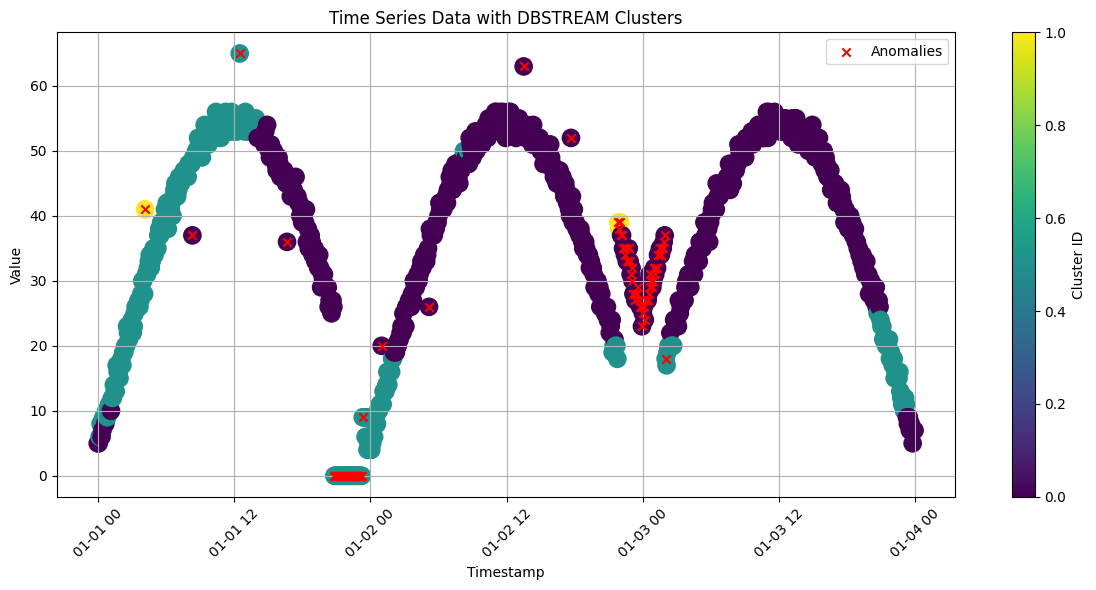

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'timestamp' column is in datetime format for plotting
synthetic_ts_df['timestamp'] = pd.to_datetime(synthetic_ts_df['timestamp'])

plt.figure(figsize=(12, 6))

plt.scatter(synthetic_ts_df['timestamp'], synthetic_ts_df['value'], c=synthetic_ts_df['cluster'], cmap='viridis', s=155)

#plt.plot(synthetic_ts_df['timestamp'], synthetic_ts_df['value'], label='Time Series', color='blue', alpha=0.7)

# Mark the anomalous points
plt.scatter(synthetic_ts_df[synthetic_ts_df['is_anomaly'] == 1]['timestamp'],
            synthetic_ts_df[synthetic_ts_df['is_anomaly'] == 1]['value'],
            color='red', label='Anomalies', zorder=5, marker='x')

plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series Data with DBSTREAM Clusters')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('dbstream_clusters.png')
plt.show()

## 💭 Evaluation and Realization

Visual evaluation of the streamed DBSCAN output demonstrates a superior ability to detect significant structural shifts within clusters compared to the RRCF algorithm. However, while DBSCAN offers higher sensitivity to these changes, the resulting density-based metrics lack the immediate interpretability of RRCF’s anomaly scores, making it difficult to present the findings in a simplified, stakeholder-friendly format.